In [1]:
import re
import nltk 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer


In [5]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [2]:
raw_data = pd.read_excel("URDU DB_DATASET.xlsx")

In [3]:
raw_data

,Sentences,Labels
0,یہ بہت خوشی کی بات ہے کہ وہ کراچی آئے ہیں ک...,1
1,یہ محض مودی کو خوش کرنے کے لیے کیا گیا,1
2,ان کا کہنا تھا کہ وہ نریندر مودی کے اس فیصلے ...,1
3,کیا وہ بھی اس خوشی میں شامل ہوں گے,1
4,تاہم خوش قسمتی سے اب تک یہ احتجاج یا انقلاب پ...,1
...,...,...
1163,فلم ’’ٹرمنیٹر ڈارک فیٹ‘‘ میں آرنلڈ اور لِنڈا ...,3
1164,ایسا لگ رہا تھا یہ میرے کیریئر کی آخری قسط ہے...,3
1165,چینی فلم’’بیٹر ڈیز‘‘کا ریلیز کے تیسرے دن 2کروڑ...,3
1166,عمران اشرف نے فلم ’’دم مستم ‘‘ سے فلمی دنیا می...,3


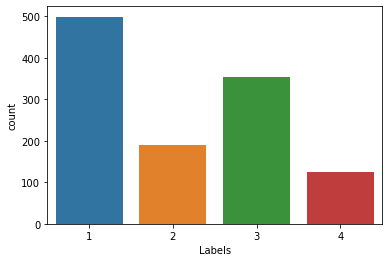

In [4]:
sentences = raw_data['Sentences'].tolist()
sentiments = raw_data['Labels'].tolist()

sns.countplot(x='Labels', data=raw_data)
plt.show()

In [5]:
def delete_urdu_english_symbols(sentences):
    cleaned = []
    for sentence in sentences:
        text = re.sub(r"\d+", " ", sentence)
        # English punctuations
        text = re.sub(r"""[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]+""", " ", text)
        # Urdu punctuations
        text = re.sub(r"[:؛؟’‘٭ء،۔]+", " ", text)
        # Arabic numbers
        text = re.sub(r"[٠‎١‎٢‎٣‎٤‎٥‎٦‎٧‎٨‎٩]+", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)
        # Remove English characters and numbers.
        text = re.sub(r"[a-zA-z0-9]+", " ", text)
        # remove multiple spaces.
        text = re.sub(r" +", " ", text)
        text = text.split(" ")
        # some stupid empty tokens should be removed.
        text = [t.strip() for t in text if t.strip()]
        cleaned.append(" ".join(text))
    return cleaned

X = delete_urdu_english_symbols(sentences)
Y = sentiments

In [6]:
stop_words = open("urdu_stopwords.txt", "r", encoding="utf-8")
stop_words = stop_words.read()
stops = stop_words.split("\n")
stops = set(stops)
stops

{'',
 'آ',
 'آئی',
 'آئیں',
 'آئے',
 'آتا',
 'آتی',
 'آتے',
 'آنا',
 'آنی',
 'آنے',
 'آپ',
 'آگے',
 'آیا',
 'اب',
 'ابھی',
 'اس',
 'اسی',
 'اسے',
 'ان',
 'انھیں',
 'انہوں',
 'انہی',
 'انہیں',
 'او',
 'اور',
 'اٹھا',
 'اپنا',
 'اپنی',
 'اپنے',
 'اگر',
 'ایسا',
 'ایسی',
 'ایسے',
 'ایک',
 'اے',
 'با',
 'بعد',
 'بعض',
 'بلکہ',
 'بڑا',
 'بڑی',
 'بڑے',
 'بھی',
 'بہت',
 'بے',
 'تا',
 'تاکہ',
 'تب',
 'تجھ',
 'تجھے',
 'تم',
 'تمام',
 'تمھارے',
 'تمھیں',
 'تمہارا',
 'تمہاری',
 'تمہارے',
 'تمہیں',
 'تو',
 'تک',
 'تھا',
 'تھی',
 'تھیں',
 'تھے',
 'تیری',
 'تیرے',
 'جا',
 'جاؤ',
 'جائیں',
 'جائے',
 'جاتا',
 'جاتی',
 'جاتے',
 'جانی',
 'جانے',
 'جب',
 'جس',
 'جن',
 'جنہوں',
 'جنہیں',
 'جو',
 'جیسا',
 'جیسوں',
 'جیسی',
 'جیسے',
 'حالانکہ',
 'حالاں',
 'دو',
 'دونوں',
 'دوں',
 'دی',
 'دیئے',
 'دیا',
 'دیتا',
 'دیتی',
 'دیتے',
 'دینا',
 'دینی',
 'دینے',
 'دیں',
 'دیے',
 'دے',
 'ذرا',
 'رکھا',
 'رکھتا',
 'رکھتی',
 'رکھتے',
 'رکھنا',
 'رکھنی',
 'رکھنے',
 'رکھی',
 'رکھے',
 'رہ',
 'رہا',
 'رہتا',
 'رہتی',
 'ر

In [7]:
filtered_sentence = [''] * len(X)
NoStopWords = list()
NoStopWords_Dict = dict()

for index in range(0, len(X)):
    split_sentence = X[index].split()
    for word in split_sentence:  
        if word not in stop_words:
            NoStopWords.append(word)
            filtered_sentence[index] = filtered_sentence[index]+" "+word
#             print('Hey')
    NoStopWords_Dict[index] = NoStopWords
    NoStopWords = []

In [8]:
NoStopWords_Dict

{0: ['خوشی',
  'بات',
  'کراچی',
  'شہر',
  'کئی',
  'برس',
  'ہوچکے',
  'بین',
  'الاقوامی',
  'میچ',
  'میزبانی'],
 1: ['محض', 'مودی', 'خوش'],
 2: ['کہنا',
  'نریندر',
  'مودی',
  'فیصلے',
  'خوش',
  'دولت',
  'مند',
  'لوگوں',
  'اترے',
  'چہرے',
  'دیکھ',
  'خوشی'],
 3: ['خوشی', 'شامل'],
 4: ['تاہم', 'خوش', 'قسمتی', 'احتجاج', 'انقلاب', 'پرامن'],
 5: ['مزید',
  'کہتے',
  'شاہ',
  'رخ',
  'تر',
  'کردار',
  'متوسط',
  'اعلی',
  'طبقے',
  'لڑکے',
  'متوجہ',
  'محفوظ',
  'خوش'],
 6: ['شاہ', 'رخ', 'خان', 'کردار', 'زندگی', 'خوش', 'خرم', 'بس', 'محبت'],
 7: ['خوش', 'پرجوش', 'محسوس'],
 8: ['خوشی', 'ذمہ', 'داری', 'قبول'],
 9: ['نئی',
  'تحقیق',
  'معلوم',
  'آمدن',
  'دگنی',
  'نسبت',
  'اچھی',
  'صحت',
  'اچھا',
  'شریک',
  'زندگی',
  'لوگوں',
  'زندگیوں',
  'خوش',
  'خرم',
  'بناتا'],
 10: ['پتہ',
  'ڈپریشن',
  'بےچینی',
  'بیماری',
  'لوگوں',
  'خوشی',
  'اثرانداز',
  'اچھے',
  'شریک',
  'حیات',
  'وجہ',
  'خوشی',
  'نصیب'],
 11: ['سائنس',
  'دانوں',
  'معلوم',
  'آمدن',
  'دگنی',
  'دس',

In [9]:
X = filtered_sentence
print(X)

[' خوشی بات کراچی شہر کئی برس ہوچکے بین الاقوامی میچ میزبانی', ' محض مودی خوش', ' کہنا نریندر مودی فیصلے خوش دولت مند لوگوں اترے چہرے دیکھ خوشی', ' خوشی شامل', ' تاہم خوش قسمتی احتجاج انقلاب پرامن', ' مزید کہتے شاہ رخ تر کردار متوسط اعلی طبقے لڑکے متوجہ محفوظ خوش', ' شاہ رخ خان کردار زندگی خوش خرم بس محبت', ' خوش پرجوش محسوس', ' خوشی ذمہ داری قبول', ' نئی تحقیق معلوم آمدن دگنی نسبت اچھی صحت اچھا شریک زندگی لوگوں زندگیوں خوش خرم بناتا', ' پتہ ڈپریشن بےچینی بیماری لوگوں خوشی اثرانداز اچھے شریک حیات وجہ خوشی نصیب', ' سائنس دانوں معلوم آمدن دگنی دس پیمانے خوشی صفر درجے قریب بلند', ' تاہم اچھا شریک حیات مل خوشی صفر درجے اضافہ شریک حیات موت علیحدگی قدر کمی واقع', ' تاہم پیمانے منفی اثر ڈپریشن بےچینی بیماری پڑتا خوشی صفر سات درجے', ' کہنا مریم نواز ہوشیار خود خوش اسلوبی ساتھ عوام پیش', ' خاندان مطابق اداکارہ سری دیوی شوہر بونی کپور بیٹی خوشی ساتھ شادی تقریب شرکت دبئی موجود', ' سری دیوی فلم پروڈیوسر بونی کپور سنہ انیس چھیانوے شادی خوشی جھانوی کپور بیٹیاں', ' پشاور زلمی ایمرجنگ کیٹگری شامل دوتی

In [13]:
NonStop_List = list()
for key, value in NoStopWords_Dict.items():
    NonStop_List.append(value)
    
print(NonStop_List[0])

['خوشی', 'بات', 'کراچی', 'شہر', 'کئی', 'برس', 'ہوچکے', 'بین', 'الاقوامی', 'میچ', 'میزبانی']


In [18]:
cleaned_df = pd.DataFrame(data=X , columns = ['Sentences'])
cleaned_df['Labels'] = raw_data['Labels']
# for index in range(0, len(X)):
cleaned_df['WithoutStopwords'] = NonStop_List
cleaned_df['Sentences'][1]

' محض مودی خوش'

In [12]:
# from nltk.stem import PorterStemmer
# Lematize = nltk.WordNetLemmatizer()

# stemObj = PorterStemmer()
# stemWords = list()
# LematizeList = list()
# for index in range(0, len(X)):
#     stemWords.append([stemObj.stem(word) for word in cleaned_df["WithoutStopwords"][index]])
#     LematizeList.append([Lematize.lemmatize(word) for word in cleaned_df["WithoutStopwords"][index]])

In [13]:
# for words in cleaned_df['WithoutStopwords'].iteritems():
#     stemWords.append([stemObj.stem(word) for word in words])
#     LematizeList.append([Lematize.lemmatize(word) for word in words])

In [14]:
# cleaned_df["Stemming"] = stemWords
# cleaned_df["Lemmatizing"] = LematizeList
# cleaned_df

,Sentences,Labels,WithoutStopwords,Stemming,Lemmatizing
0,خوشی بات کراچی شہر کئی برس ہوچکے بین الاقوامی...,1,"[خوشی, بات, کراچی, شہر, کئی, برس, ہوچکے, بین, ...","[خوشی, بات, کراچی, شہر, کئی, برس, ہوچکے, بین, ...","[خوشی, بات, کراچی, شہر, کئی, برس, ہوچکے, بین, ..."
1,محض مودی خوش,1,"[محض, مودی, خوش]","[محض, مودی, خوش]","[محض, مودی, خوش]"
2,کہنا نریندر مودی فیصلے خوش دولت مند لوگوں اتر...,1,"[کہنا, نریندر, مودی, فیصلے, خوش, دولت, مند, لو...","[کہنا, نریندر, مودی, فیصلے, خوش, دولت, مند, لو...","[کہنا, نریندر, مودی, فیصلے, خوش, دولت, مند, لو..."
3,خوشی شامل,1,"[خوشی, شامل]","[خوشی, شامل]","[خوشی, شامل]"
4,تاہم خوش قسمتی احتجاج انقلاب پرامن,1,"[تاہم, خوش, قسمتی, احتجاج, انقلاب, پرامن]","[تاہم, خوش, قسمتی, احتجاج, انقلاب, پرامن]","[تاہم, خوش, قسمتی, احتجاج, انقلاب, پرامن]"
...,...,...,...,...,...
1163,فلم ٹرمنیٹر ڈارک فیٹ رنلڈ نڈا ہیملٹن واپسی,3,"[فلم, ٹرمنیٹر, ڈارک, فیٹ, رنلڈ, نڈا, ہیملٹن, و...","[فلم, ٹرمنیٹر, ڈارک, فیٹ, رنلڈ, نڈا, ہیملٹن, و...","[فلم, ٹرمنیٹر, ڈارک, فیٹ, رنلڈ, نڈا, ہیملٹن, و..."
1164,کیریئر خری قسط ہمایوں سعید,3,"[کیریئر, خری, قسط, ہمایوں, سعید]","[کیریئر, خری, قسط, ہمایوں, سعید]","[کیریئر, خری, قسط, ہمایوں, سعید]"
1165,چینی فلم بیٹر ڈیز ریلیز تیسرے دن کروڑ لاکھ ڈا...,3,"[چینی, فلم, بیٹر, ڈیز, ریلیز, تیسرے, دن, کروڑ,...","[چینی, فلم, بیٹر, ڈیز, ریلیز, تیسرے, دن, کروڑ,...","[چینی, فلم, بیٹر, ڈیز, ریلیز, تیسرے, دن, کروڑ,..."
1166,عمران اشرف فلم دم مستم فلمی دنیا قدم,3,"[عمران, اشرف, فلم, دم, مستم, فلمی, دنیا, قدم]","[عمران, اشرف, فلم, دم, مستم, فلمی, دنیا, قدم]","[عمران, اشرف, فلم, دم, مستم, فلمی, دنیا, قدم]"


In [15]:
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2 )

In [16]:
# print(len(Xtrain))
# print(len(Xtest))
# print(len(Ytrain))
# print(len(Ytest))


934
234
934
234


# Logistic Regression model using feature extraction algorithm TfidfVectorizer

In [17]:
# max_feature_num = 5000
# train_vectorizer = TfidfVectorizer(max_features=max_feature_num)
# train_vecs = train_vectorizer.fit_transform(Xtrain)
# test_vecs = TfidfVectorizer(max_features=max_feature_num,vocabulary=train_vectorizer.vocabulary_).fit_transform(Xtest)

# # train model
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression().fit(train_vecs, Ytrain)

# # test model
# test_pred = clf.predict(test_vecs)
# from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# acc = accuracy_score(Ytest, test_pred)
# pre, rec, f1, _ = precision_recall_fscore_support(Ytest, test_pred, average='macro')
# print('acc', acc)
# print('precision', pre)
# print('rec', rec)
# print('f1', f1)

acc 0.8888888888888888
precision 0.9025568181818182
rec 0.7939956328066636
f1 0.8193257053104559


# Logistic Regression model using a feature extraction algorithm bag of words (CountVectorizer)

In [18]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# CV = vectorizer.fit_transform(X)
# print(vectorizer.get_feature_names())

['آؤٹ', 'آئند', 'آئٹم', 'آبائی', 'آباد', 'آتشزدگی', 'آج', 'آخرالزمان', 'آخری', 'آر', 'آرتھوپیڈک', 'آرٹس', 'آرچ', 'آرڈر', 'آرہا', 'آرہی', 'آسان', 'آسانی', 'آسٹریلوی', 'آسٹریلیا', 'آصبح', 'آصف', 'آغاز', 'آف', 'آفتاب', 'آمد', 'آمدن', 'آمدنی', 'آمدید', 'آمنہ', 'آمیزش', 'آواز', 'آٹا', 'آٹھ', 'آپریشن', 'آپکا', 'آپکی', 'آچانک', 'آکر', 'آکسیجن', 'آگئی', 'آگر', 'آیندہ', 'ؤٹ', 'ئند', 'ئندہ', 'اآرٹس', 'ائیر', 'ائیرپورٹس', 'ابتدائی', 'ابدال', 'ابرالحق', 'ابوالخیر', 'ابیب', 'اتار', 'اتحاد', 'اترا', 'اترے', 'اتنا', 'اتنی', 'اتھارٹی', 'اثر', 'اثرانداز', 'اجاگر', 'اجتناب', 'اجلاس', 'اجمل', 'احتجاج', 'احتجاجی', 'احتساب', 'احد', 'احسن', 'احمد', 'اخبار', 'اختتام', 'اختتامی', 'اختلاف', 'اختیا', 'اختیار', 'ادا', 'ادائیگی', 'اداروں', 'ادارہ', 'ادارے', 'اداکار', 'اداکارائوں', 'اداکارائیں', 'اداکاروں', 'اداکارہ', 'اداکاری', 'اداکرنا', 'ادراہ', 'ادویات', 'ادکاارہ', 'ادھر', 'اذان', 'اذیت', 'اراضی', 'ارباز', 'ارسلان', 'ارشد', 'ارمینا', 'ارمینہ', 'ارون', 'از', 'ازجلد', 'ازکم', 'اساتذہ', 'اسبملی', 'استاد', 'استحکا

In [19]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(binary=True, analyzer='word', tokenizer=nltk.word_tokenize)
# cv.fit(X)
# Count_Vec_X_Data = cv.transform(X)

C:\Users\Nadeem Khan\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [20]:
# Count_Vec_X_Data.shape

(1168, 3518)

In [21]:
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(Count_Vec_X_Data, Y, test_size=0.2 )

In [22]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression().fit(Xtrain, Ytrain)

# # test model
# test_pred = clf.predict(Xtest)
# from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# acc = accuracy_score(Ytest, test_pred)
# pre, rec, f1, _ = precision_recall_fscore_support(Ytest, test_pred, average='macro')
# print('acc', acc)
# print('precision', pre)
# print('rec', rec)
# print('f1', f1)

acc 0.9358974358974359
precision 0.9395317415503751
rec 0.9053159379701409
f1 0.919431061875877


# SVM (support vector machine predictor) to bag of words (CountVectorizer)

In [23]:
# from sklearn.svm import SVC
# clf = svm.SVC(kernel='linear').fit(Xtrain, Ytrain)

# # test model
# test_pred = clf.predict(Xtest)
# from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# acc = accuracy_score(Ytest, test_pred)
# pre, rec, f1, _ = precision_recall_fscore_support(Ytest, test_pred, average='macro')
# print('acc', acc)
# print('precision', pre)
# print('rec', rec)
# print('f1', f1)

acc 0.9401709401709402
precision 0.9439115646258504
rec 0.919132659746239
f1 0.9302006776454929


In [ ]:
word2vec 
fasttext
apply lstm